In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from env import SimpleModel, GeneralSimpleModel
from wrappers import ImpactWrapper

# Model Based RL Simple model

In [3]:
# true system params
big_b=1
big_omega=1
theta=0
m=1
k=0.1
beta=0.02
big_f_0=1
t_min=0
t_max=10

t0 = 0
t_step = 1
n_steps = 8
n_prev = 3

delta = beta / (2 * m)
omega_0 = k / m

impact_amplitude = 1
damping_ratio = 0.05

In [4]:
def x_impact(t, a=impact_amplitude, b=damping_ratio):
#     if t < 0:
#         return 1
    return a * np.exp(-t * b)

def x_pendulum(t, big_b, big_omega, theta):
    return big_b * np.cos(big_omega * t - theta)

def generate_history(t0, step, n_steps, big_b=big_b, big_omega=big_omega, theta=theta,
                     impact=x_impact, x_pendulum=x_pendulum):
    res = []
    for _ in range(n_steps):
        res.append(
            x_pendulum(t0, big_b, big_omega, theta) * impact(t0)
        )
        t0 += step
    return res

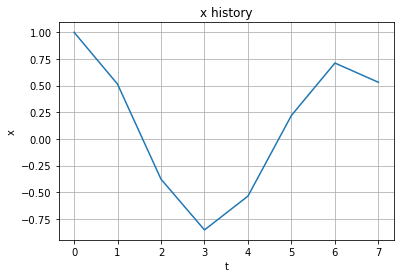

In [5]:
history = generate_history(t0, t_step, n_steps)

plt.title("x history")
plt.xlabel("t")
plt.ylabel("x")
plt.grid(True)
plt.plot(history)
plt.show()

In [6]:
history = generate_history(t0=t0, step=t_step, n_steps=n_steps, impact=lambda t: 1)
env = SimpleModel(history=history, t0=t0, t_step=t_step, n_steps=n_steps, big_f_0=big_f_0, k=k, n_prev=n_prev)

In [7]:
env.action_space.high

array([10. ,  2. ,  0.1], dtype=float32)

In [8]:
for i in range(20):
    env.reset()
    o, r, d, _ = env.step([m, delta, big_omega])
    assert np.isclose(r, 0, atol=1e-3)
o, r, d, _ = env.step([m, delta, big_omega + 1])
assert not np.isclose(r, 0, atol=1e-3)

reset_1 = env.reset()
for i in range(n_steps-n_prev):
    o, r, d, _ = env.step([0.1, 0.1, 0.1])
reset_2 = env.reset()
assert np.all(reset_1 == reset_2)

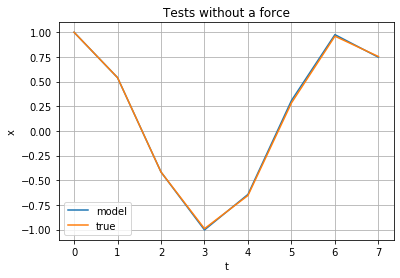

In [9]:
points = list(env.reset().reshape((-1,)))
points += [env.step([m, delta, big_omega])[0][-1][0] for _ in range(len(history) - n_prev)]
points = np.array(points).reshape((-1,))

# assert len(points) == len(history)
# for p, h in zip(*(points, history)):
#     assert np.isclose(p, h, atol=1e-1)
plt.plot(np.array(points).reshape((-1,1)), label="model")
plt.plot(history, label="true")
plt.grid(True)
plt.legend()
plt.title("Tests without a force")
plt.xlabel("t")
plt.ylabel("x")
plt.show()

In [10]:
history = generate_history(t0=t0, step=t_step, n_steps=n_steps, impact=x_impact)
env = SimpleModel(history=history, t0=t0, t_step=t_step, n_steps=n_steps, big_f_0=big_f_0, k=k, n_prev=n_prev)
env = ImpactWrapper(env, x_impact, param1=impact_amplitude, param2=damping_ratio)

In [11]:
# points = [env.reset()]
# points += [env.step([m, delta, big_omega])[0] for _ in range(len(history) - 1)]
# points = np.array(points).T

# assert points[0].shape == points[1].shape
# plt.plot(points[0]*points[1] + 0.01, label="model with force")
# plt.plot(points[0], label="model")
# plt.plot(points[1], label="force")
# plt.plot(history, label="true")
# plt.grid(True)
# plt.legend()
# plt.title("Tests with a force")
# plt.xlabel("t")
# plt.ylabel("x")
# plt.show()

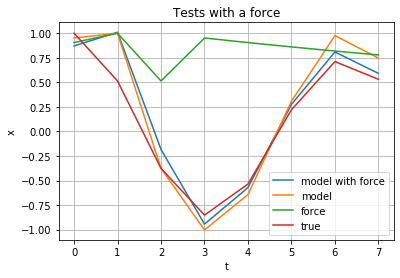

In [12]:
points = list(env.reset().reshape((-1,))[2:].reshape((-1,2)))
points += [env.step([m, delta, big_omega])[0][n_prev+1::n_prev] for _ in range(len(history) - n_prev)]
points = np.array(points).T

assert points[0].shape == points[1].shape
plt.plot(points[0]*points[1] + 0.01, label="model with force")
plt.plot(points[1], label="model")
plt.plot(points[0], label="force")
plt.plot(history, label="true")
plt.grid(True)
plt.legend()
plt.title("Tests with a force")
plt.xlabel("t")
plt.ylabel("x")
plt.show()

# RL Simple Model

In [13]:
history = generate_history(t0=t0, step=t_step, n_steps=n_steps, impact=lambda t: 1)
env = GeneralSimpleModel(history=history, t0=t0, t_step=t_step, n_steps=n_steps, big_f_0=big_f_0, k=k, n_prev=n_prev)

In [14]:
# true x test
env.reset()
for x in history[n_prev:]:
    o, r, d, _ = env.step([x])
    assert np.isclose(r, 0, atol=1e-3)

# false x test
env.reset()
o, r, d, _ = env.step([x + 1])
assert not np.isclose(r, 0, atol=1e-3)

# sth changes test
reset_1 = env.reset()
for i in range(n_steps-n_prev):
    o, r, d, _ = env.step([0.1])
reset_2 = env.reset()
assert np.all(reset_1 == reset_2)

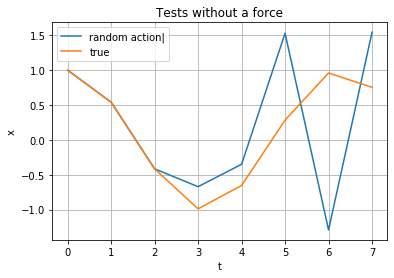

In [15]:
env.reset()
env.step(env.action_space.sample())
points = list(env.reset().reshape((-1,)))
points += [env.step(env.action_space.sample())[0][-1] for x in history[n_prev:]]

# assert len(points) == len(history)
# for p, h in zip(*(points, history)):
#     assert np.isclose(p, h, atol=1e-1)
plt.plot(np.array(points).reshape((-1,1)), label="random action|")
plt.plot(history, label="true")
plt.grid(True)
plt.legend()
plt.title("Tests without a force")
plt.xlabel("t")
plt.ylabel("x")
plt.show()

In [16]:
history = generate_history(t0, t_step, n_steps, impact=x_impact)
env = GeneralSimpleModel(history, t0, t_step, n_steps, big_f_0, k, n_prev)
env = ImpactWrapper(env, x_impact, param1=impact_amplitude, param2=damping_ratio)